# Interpretable Machine Learning with LIME for Image Classification

In [1]:
# 导入包
import os
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import copy
import matplotlib.pyplot as plt
import numpy as np

2023-01-18 21:06:42.986462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 21:06:43.164196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 21:06:43.164231: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-18 21:06:44.403643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7:

## 载入模型

In [2]:
# 下载Google_Inception net-v3深度神经网络模型
model = InceptionV3(weights='imagenet', include_top=True)

# 查看模型架构
print(model.summary())

2023-01-18 21:06:49.748418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 21:06:49.748560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 21:06:49.748642: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-18 21:06:49.748716: W tensorflow/compiler/xla/stream_executor/platform/defa

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

## 读取图片并做预处理操作

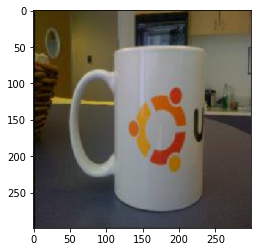

In [4]:
from keras.utils import image_utils
img_path = "./mug.jpg"
img = image_utils.load_img(img_path, target_size=(299, 299)) # 导入图片
Xi = image_utils.img_to_array(img) # 将图片转化为 array 数据
Xi = np.expand_dims(Xi, axis=0) # shape=(1, 299, 299, 3)，相当于batch_size=1
Xi = keras.applications.inception_v3.preprocess_input(Xi) # 对图片进行预处理

plt.imshow((Xi[0]/2 + 0.5)) # Xi[0]相当于读取整个图片，即(299,299,3)

## 预测图片

In [5]:
yhat = model.predict(Xi)
for x in decode_predictions(yhat)[0]:
    print(x)

35363/35363 [==============================] - 0s 2us/step
('n03063599', 'coffee_mug', 0.7765415)
('n07930864', 'cup', 0.049692083)
('n03063689', 'coffeepot', 0.011346712)
('n04560804', 'water_jug', 0.007289998)
('n04579145', 'whiskey_jug', 0.0034664476)


In [38]:
top_pred_classes = yhat[0].argsort()[-5:][::-1]
top_pred_classes

array([504, 968, 505, 899, 901])

# LIME explanations

## Step1：建立超像素（Super Pixel）产生多个扰动样本
使用快速移位分割（quickshift）演算法生成超像素

In [7]:
import skimage.segmentation as segmentation
# 将原始图片分块，superpixels.shape=(299,299)
# 在指定位置标记上所属块
superpixels = segmentation.quickshift(Xi[0], kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels
'''
np.unique(superpixels)
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])
       
superpixels
array([[ 0,  0,  0, ...,  4,  4,  4],
       [ 0,  0,  0, ...,  4,  4,  4],
       [ 0,  0,  0, ...,  4,  4,  4],
       ...,
       [46, 46, 46, ..., 48, 48, 48],
       [46, 46, 46, ..., 48, 48, 48],
       [46, 46, 46, ..., 48, 48, 48]])
'''

52

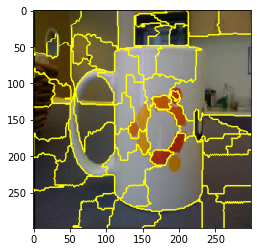

In [9]:
plt.imshow(segmentation.mark_boundaries(Xi[0]/2 + 0.5, superpixels))

产生多个随机的扰动样本，对于每个超像素指派{0，1}：0表示灰色；1表示原本色彩

In [12]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels)) # shape=(150, 52)
perturbations[0] # 显示第一个扰动样本

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1])

In [13]:
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0] # 指定perturbation值为1时的下标
    mask = np.zeros(segments.shape) # (299,299) 全0
    for active in active_pixels:
        mask[segments == active] = 1 # 根据perturbation值为1所对应的区块，将mask对应的区块值设置为1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis] # (299,299,3) * (299, 299, 1)
    '''
    以深度为0时为例
    （299, 3) * (299, 1)表示前者（共有三列）每列都与后者（只有一列）的列相乘
    '''
    return perturbed_image

In [22]:
active_pixels = np.where(perturbations[0] == 1)[0]
active_pixels

array([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 15, 17, 20, 22, 23, 24, 25, 28,
       29, 30, 31, 32, 35, 36, 37, 38, 40, 41, 43, 44, 46, 48, 49, 51])

In [26]:
mask[superpixels == active_pixels[0]] = 1
mask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
superpixels == active_pixels[0]

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

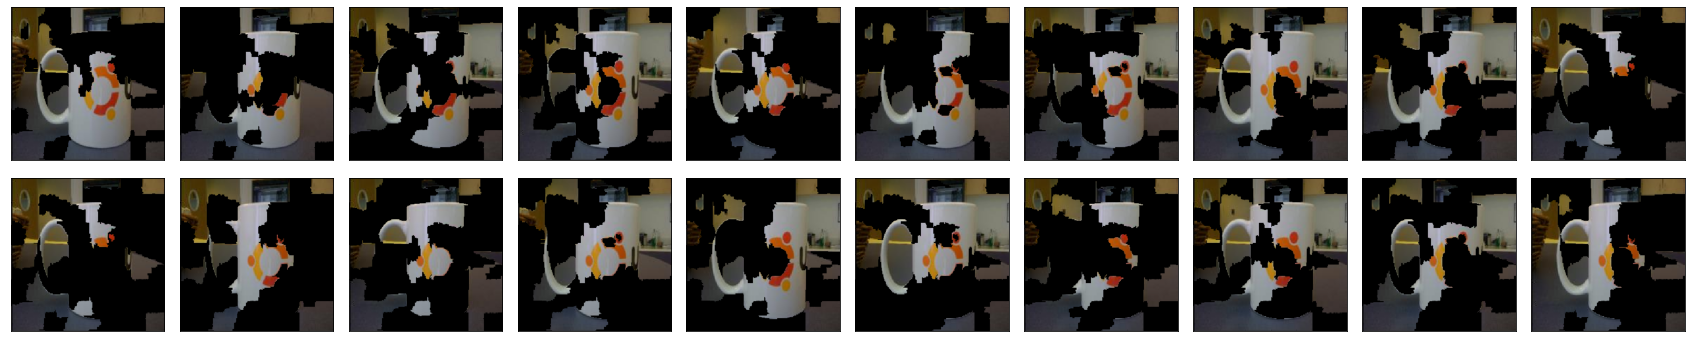

In [18]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6),
                      subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(perturb_image(Xi[0]/2+0.5, perturbations[i], superpixels))
    ax[1, i].imshow(perturb_image(Xi[0]/2+0.5, perturbations[i+9], superpixels))

## Step2：使用ML分类器预测新生成的图像类别

In [34]:
predictions = []
# f(z)
for pert in perturbations:
    perturbed_img = perturb_image(Xi[0], pert, superpixels)
    pred = model.predict(np.expand_dims(perturbed_img, axis=0))
    predictions.append(pred)
    
predictions = np.array(predictions)
predictions.shape

1/1 [==============================] - 0s 114ms/step


(150, 1, 1000)

In [42]:
predictions

array([[[4.25656835e-05, 8.53286037e-05, 1.59012896e-04, ...,
         1.29462263e-04, 2.56847445e-04, 2.71262339e-04]],

       [[1.16763695e-04, 2.86074763e-04, 1.54633366e-04, ...,
         2.04728189e-04, 1.21867095e-04, 9.35770629e-04]],

       [[1.65394595e-05, 3.96391879e-05, 4.38127317e-05, ...,
         9.69403482e-05, 4.78674592e-05, 3.19203013e-03]],

       ...,

       [[9.83123391e-05, 1.60723604e-04, 2.46274285e-04, ...,
         9.15266864e-05, 1.90243867e-04, 1.77041418e-03]],

       [[8.58040767e-06, 2.80533222e-05, 7.87107729e-06, ...,
         5.81965332e-06, 4.61912123e-06, 1.38938343e-02]],

       [[1.49394575e-04, 1.89053462e-04, 1.05580191e-04, ...,
         5.51764060e-05, 7.05753991e-05, 1.42338127e-03]]], dtype=float32)

## Step3：计算原始图像与新生成图像之间的距离，并计算每个新生成图像的权重（相似性）

In [35]:
from sklearn import metrics
original_image = np.expand_dims(np.ones(num_superpixels), axis=0) # 原始图片每个超像素块x'=1
original_image

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

In [36]:
distances = metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()
distances.shape

(150,)

使用核函数计算权重$\pi_x(z)=exp(\frac{-D(x,z)^2}{\sigma^2})$

In [37]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) # kernel function
weights.shape

(150,)

## Step4：使用`perturbations`，`predictions`和`weights`去拟合可解释模型（线性）

In [39]:
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01979167, -0.0132694 , -0.00960429,  0.02001737,  0.00446463,
       -0.01788187,  0.01111496, -0.05951688,  0.05674493,  0.02980495,
       -0.01471047,  0.03107395,  0.09950637,  0.02866331, -0.00258388,
       -0.01708884,  0.0408538 ,  0.00902899,  0.04394271,  0.01965968,
        0.01167358,  0.02955862, -0.0074612 ,  0.18335746,  0.09029392,
        0.06135452,  0.02953861, -0.05636378,  0.03548036,  0.04555296,
       -0.09432192,  0.00202529,  0.21826787,  0.02815464, -0.04952745,
        0.01682952,  0.00400754, -0.02832042, -0.04664622,  0.00301374,
        0.14174523,  0.15032692,  0.01291304, -0.0156231 , -0.03365997,
       -0.03651895,  0.02647397,  0.02110183,  0.04489331, -0.08245459,
       -0.14259657, -0.06966448])

In [47]:
simpler_model.coef_.shape

(1, 52)

In [41]:
predictions[:,:,class_to_explain].shape # 取所有深度，所有行，class_to_explain列的数据

(150, 1)

计算top features（superpixels）：根据系数由大至小排列

In [43]:
num_top_features = 10
top_features = np.argsort(coeff)[-num_top_features:]
top_features

array([48, 29,  8, 25, 24, 12, 40, 41, 23, 32])

显示LIME explanation（image with top features）

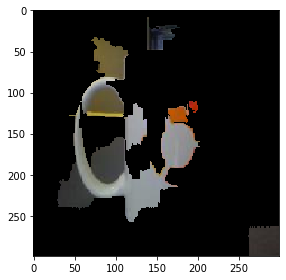

In [45]:
import skimage
mask = np.zeros(num_superpixels)
mask[top_features] = True
skimage.io.imshow(perturb_image(Xi[0]/2+0.5, mask, superpixels))

In [48]:
np.argsort(coeff)

array([50, 30, 49, 51,  7, 27, 34, 38, 45, 44, 37,  5, 15, 43, 10,  1,  2,
       22, 14, 31, 39, 36,  4, 17,  6, 20, 42, 35, 19,  0,  3, 47, 46, 33,
       13, 26, 21,  9, 11, 28, 16, 18, 48, 29,  8, 25, 24, 12, 40, 41, 23,
       32])

In [49]:
np.argsort(coeff)[-10:]

array([48, 29,  8, 25, 24, 12, 40, 41, 23, 32])

# LIME套件

In [50]:
# 建立解释器
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [51]:
# 定义图片分割方式
def segment_fn(image):
    return segmentation.quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)

In [52]:
# 针对被解释实例训练解释器
explanation = explainer.explain_instance(Xi[0].astype('double'), model.predict, top_labels=5, num_samples=1000, segmentation_fn=segment_fn)

1/1 [==============================] - 1s 1s/step



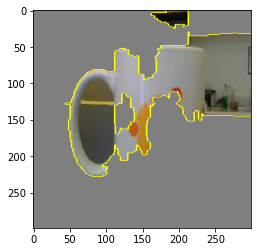

In [53]:
# 进行解释
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

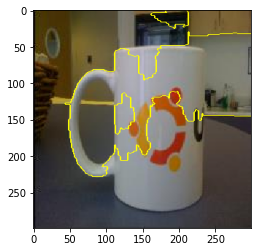

In [54]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

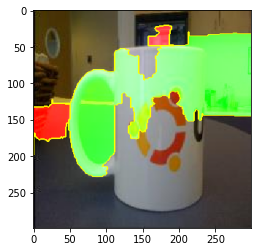

In [55]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))